<a href="https://colab.research.google.com/github/ydsyvn/NN-from-scratch/blob/main/NN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
NUM_CLASSES = 10

In [3]:
import tensorflow as tf
import numpy as np

# Load MNIST using TensorFlow/Keras (you can change this to another library if you prefer)
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Custom one-hot encoding function
def one_hot_encode(y, num_classes=10):
    encoded = np.zeros((y.size, num_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

# Apply custom one-hot encoding
y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


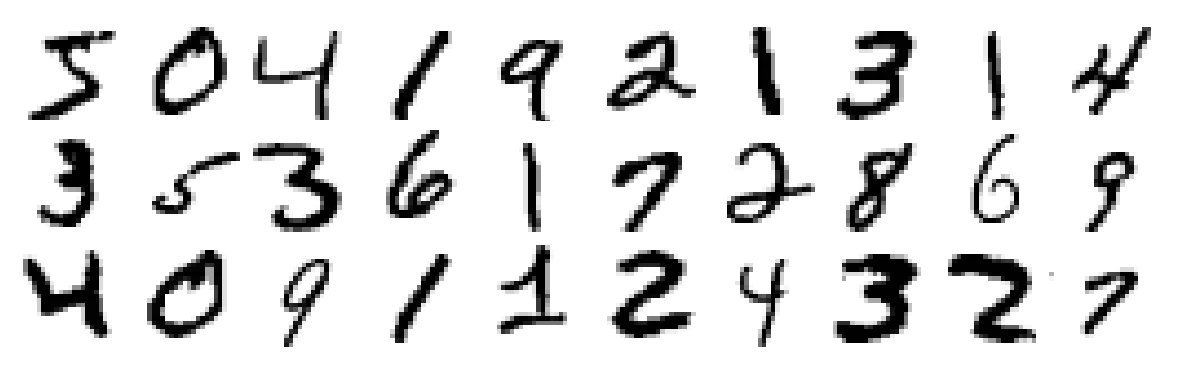

In [4]:
plt.figure(figsize=(15,4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [12]:
class DeepNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights
        self.W1 = self.xavier_glorot_initialization(self.input_size, self.hidden_size)
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = self.xavier_glorot_initialization(self.hidden_size, self.output_size)
        self.b2 = np.zeros((1, self.output_size))

        self.loss_history = []
        self.accuracy_history = []

        self.test_loss_history = []
        self.test_accuracy_history = []

    def xavier_glorot_initialization(self, fan_in, fan_out):
        """Initializes weights with Xavier/Glorot initialization"""
        fan_avg = (fan_in + fan_out) / 2
        variance = 1 / fan_avg
        limit = np.sqrt(3 * variance)
        weights = np.random.uniform(-limit, limit, size=(fan_in, fan_out))

        return weights

    def sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-x))

    def relu(self, x):
        """ReLU activation function"""
        return np.maximum(0, x)

    def sigmoid_derivative(self, x):
        """Derivative of the sigmoid function"""
        return x * (1 - x)

    def relu_derivative(self, x):
        """Derivative of the ReLU function"""
        return np.where(x > 0, 1, 0)

    def softmax(self, x):
        """Softmax activation function"""
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

    def forward(self, A_in):
        """Forward pass"""
        self.z1 = np.dot(A_in, self.W1) + self.b1
        self.a1 = self.relu(self.z1)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)

        return self.a2

    def loss(self, y_true, y_pred):
        L = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        return L

    def backward(self, X, y):
        """Backward pass """
        m = X.shape[0]

        delta2 = self.a2.copy()
        delta2[np.arange(m), y.argmax(axis=1)] -= 1  # Derivative of cross-entropy with softmax

        dW2 = np.dot(self.a1.T, delta2) / m
        db2 = np.sum(delta2, axis=0, keepdims=True) / m

        delta1 = np.dot(delta2, self.W2.T) * self.relu_derivative(self.z1)
        dW1 = np.dot(X.T, delta1) / m
        db1 = np.sum(delta1, axis=0, keepdims=True) / m

        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    def train(self, X, y, X_test, y_test, epochs=100, batch_size=32):
        """Training loop"""
        n_samples = X.shape[0]

        for epoch in range(epochs):
            # Mini batch gradient descent
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                # Forward and backward pass
                y_pred = self.forward(X_batch)
                self.backward(X_batch, y_batch)

            # Compute loss
            y_pred_all = self.forward(X)
            loss = self.loss(y, y_pred_all)
            self.loss_history.append(loss)

            # Calculate accuracy
            predictions = np.argmax(y_pred_all, axis=1)
            true_labels = np.argmax(y, axis=1)
            accuracy = np.mean(predictions == true_labels)
            self.accuracy_history.append(accuracy)

            # calculate test loss
            y_pred_test = self.forward(X_test)
            test_loss = self.loss(y_test, y_pred_test)
            self.test_loss_history.append(test_loss)

            # calculate test accuracy
            test_predictions = np.argmax(y_pred_test, axis=1)
            test_accuracy = np.mean(test_predictions == np.argmax(y_test, axis=1))
            self.test_accuracy_history.append(test_accuracy)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
            print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


    def predict(self, X):
        """Make predictions using the trained network"""
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)

    def plot_training_history(self):
        """Plot the training loss and accuracy history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        ax1.plot(self.loss_history)
        ax1.set_title('Loss During Training')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')

        ax2.plot(self.accuracy_history)
        ax2.set_title('Accuracy During Training')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')

        plt.tight_layout()
        plt.show()

    def visualize_predictions(self, X, y, samples=5):
        """Visualize some predictions"""
        predictions = self.predict(X)

        fig, axes = plt.subplots(samples, 2, figsize=(8, samples*4))
        indices = np.random.choice(len(y), samples, replace=False)

        for i, idx in enumerate(indices):
            # Original image
            if len(X.shape) == 2:  # If flattened, reshape
                img_size = int(np.sqrt(X.shape[1]))
                img = X[idx].reshape(img_size, img_size)
            else:
                img = X[idx]

            axes[i, 0].imshow(img, cmap='gray')
            axes[i, 0].set_title(f"True: {y[idx]}")
            axes[i, 0].axis('off')

            # Prediction
            axes[i, 1].text(0.5, 0.5, f"Predicted: {predictions[idx]}",
                          horizontalalignment='center', verticalalignment='center',
                          fontsize=12, color='blue')
            axes[i, 1].axis('off')

        plt.tight_layout()
        plt.show()

In [6]:
def main(epochs=50, batch_size=64):
    # Create and train the network
    input_size = X_train.shape[1]
    hidden_size = 128
    output_size = 10  # 10 digits

    # Initialize the neural network
    nn = DeepNeuralNetwork(input_size, hidden_size, output_size, learning_rate=0.1)

    # Train the network
    nn.train(X_train, y_train, X_test, y_test , epochs, batch_size)

    print("training finnished")

    return nn


In [13]:
nn = main(epochs=50, batch_size=32)

Epoch 1/50, Loss: 0.1728, Accuracy: 0.9508
Test Loss: 0.1744, Test Accuracy: 0.9478
Epoch 2/50, Loss: 0.1076, Accuracy: 0.9695
Test Loss: 0.1174, Test Accuracy: 0.9642
Epoch 3/50, Loss: 0.0864, Accuracy: 0.9748
Test Loss: 0.1030, Test Accuracy: 0.9684
Epoch 4/50, Loss: 0.0665, Accuracy: 0.9810
Test Loss: 0.0877, Test Accuracy: 0.9729
Epoch 5/50, Loss: 0.0563, Accuracy: 0.9846
Test Loss: 0.0832, Test Accuracy: 0.9739
Epoch 6/50, Loss: 0.0472, Accuracy: 0.9866
Test Loss: 0.0773, Test Accuracy: 0.9761
Epoch 7/50, Loss: 0.0409, Accuracy: 0.9887
Test Loss: 0.0748, Test Accuracy: 0.9777
Epoch 8/50, Loss: 0.0342, Accuracy: 0.9909
Test Loss: 0.0724, Test Accuracy: 0.9779
Epoch 9/50, Loss: 0.0278, Accuracy: 0.9932
Test Loss: 0.0660, Test Accuracy: 0.9788
Epoch 10/50, Loss: 0.0262, Accuracy: 0.9938
Test Loss: 0.0693, Test Accuracy: 0.9784
Epoch 11/50, Loss: 0.0244, Accuracy: 0.9940
Test Loss: 0.0721, Test Accuracy: 0.9774
Epoch 12/50, Loss: 0.0203, Accuracy: 0.9957
Test Loss: 0.0715, Test Accura

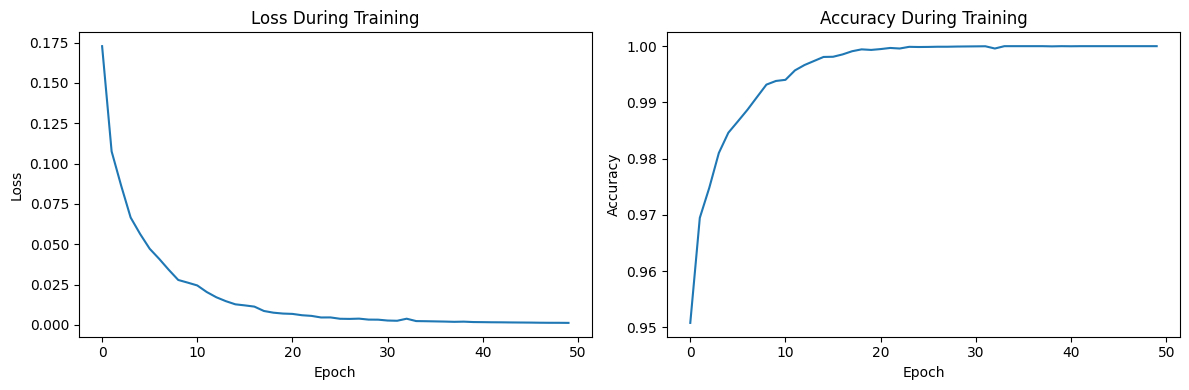

In [14]:
# Plot training history
nn.plot_training_history()

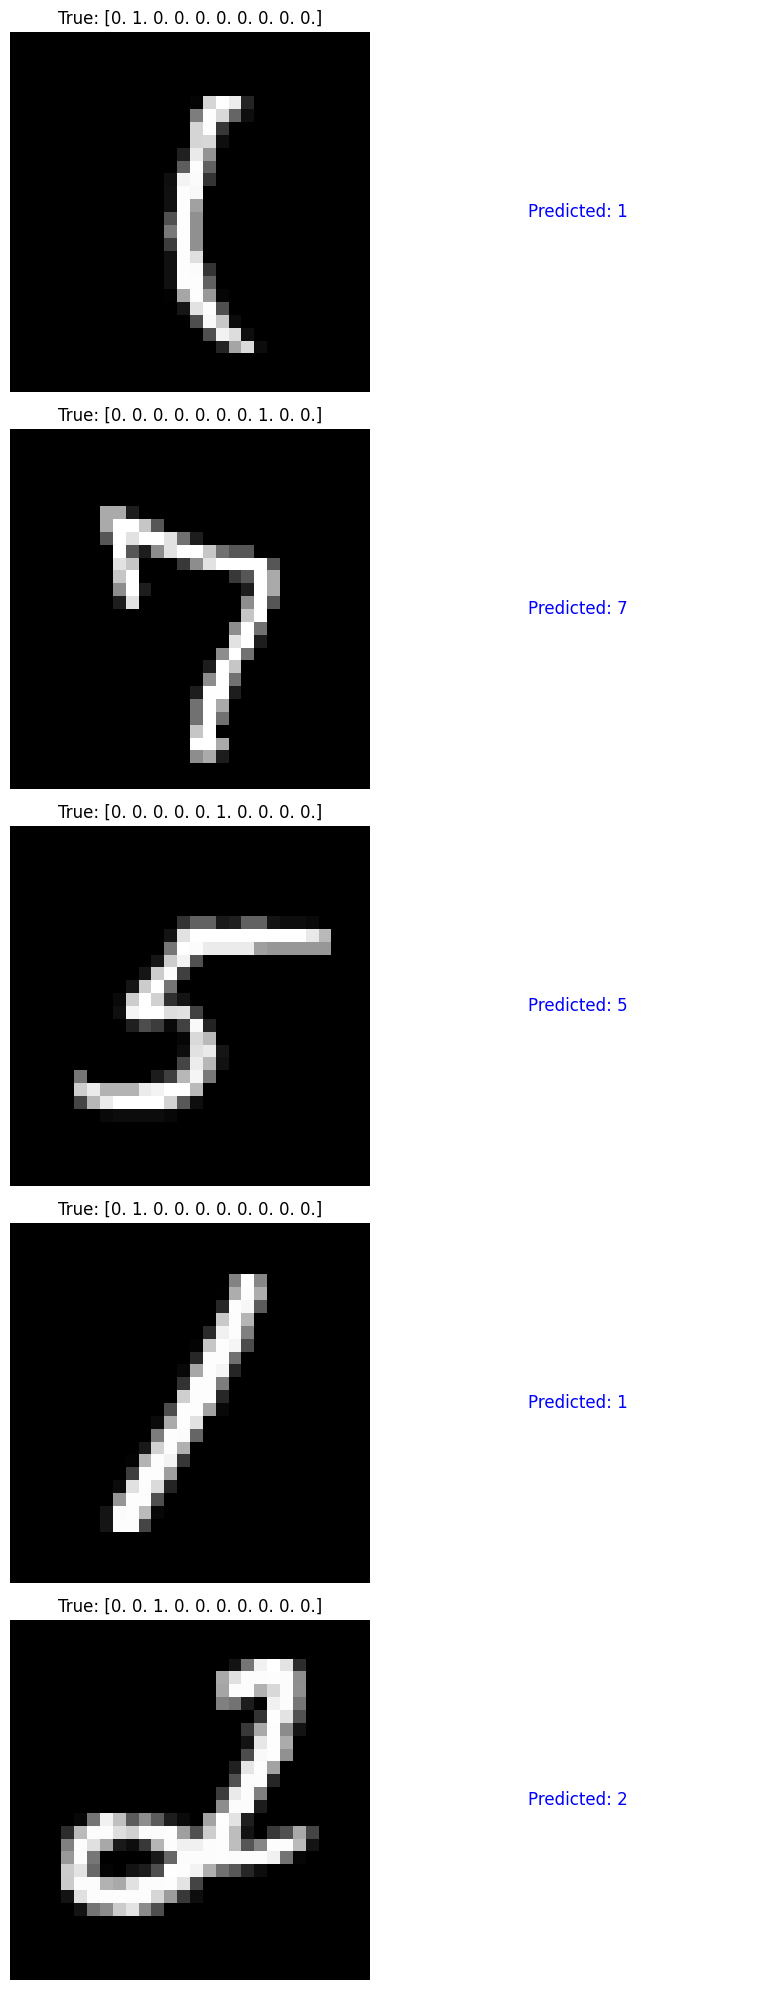

In [15]:
test_predictions = nn.predict(X_test)

nn.visualize_predictions(X_train, y_train, samples=5)